In [44]:
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata_in = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/adata_processed.h5ad')
adata_in.obs

,brain_section_label,x,y,z,x_ccf,y_ccf,z_ccf
cell_label,,,,,,,
198904341065180396762707397604803217407,Zhuang-ABCA-3.023,49.206853,44.877634,12.168155,4.920685,4.487763,1.216815
252199681526991424029643077826220097990,Zhuang-ABCA-3.023,48.973992,44.813761,12.179006,4.897399,4.481376,1.217901
277720971126854564514249564750701518375,Zhuang-ABCA-3.023,48.791066,44.577722,12.192707,4.879107,4.457772,1.219271
31551867344111790264292067056219852271,Zhuang-ABCA-3.023,48.830489,44.426120,12.195078,4.883049,4.442612,1.219508
131102494428104399865219008178262036485,Zhuang-ABCA-3.023,48.308843,43.028156,12.267879,4.830884,4.302816,1.226788
...,...,...,...,...,...,...,...
318102106429791409781741726367984532777,Zhuang-ABCA-3.009,131.090716,69.334275,41.436743,13.109072,6.933427,4.143674
35262847161560382172299767067854387528,Zhuang-ABCA-3.009,131.216032,69.494070,41.351034,13.121603,6.949407,4.135103
75415866509570969932943497000463821106,Zhuang-ABCA-3.009,131.415152,70.764504,40.800403,13.141515,7.076450,4.080040


### plot

In [3]:
section = 'Zhuang-ABCA-3.001'

In [4]:
adata_out = sc.read_h5ad(f'/mnt/Data18Td/Data/haichao/merfish_raw_data_zxw3/out_cell_adata/adata_out_cell_distance_q0.3/after_qc/{section}.h5ad')
adata_out

AnnData object with n_obs × n_vars = 83602 × 1147
    obs: 'totalRNA', 'brain_section_label', 'x', 'y', 'z', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

In [5]:
adata_in_s = adata_in[adata_in.obs['brain_section_label'] == section]

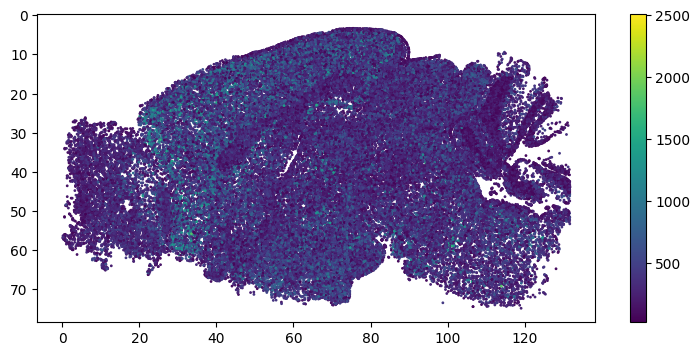

In [6]:
adata_in_s.obs['totalRNA'] = adata_in_s.X.sum(1)
plt.figure(figsize=(9,4))
plt.scatter(adata_in_s.obs['x'], adata_in_s.obs['y'], s=1, c=adata_in_s.obs['totalRNA'])
plt.colorbar()
plt.gca().invert_yaxis()
# plt.savefig('./zxw_section001.png', dpi=600)


### cell seg plot

In [7]:
k = 'spots_220609_wb3_sa1_1_5z18R_merfish5.csv'

In [8]:
path = '/mnt/Data18Td/Data/haichao/merfish_raw_data_zxw3/'
decode = pd.read_csv(path + f'decode/{k}')
decode

,barcode_id,global_x,global_y,global_z,x,y,fov,target_gene
0,6,7431.1514,-993.20215,0.0,728.81970,1755.30190,0,Blnk
1,9,7449.9080,-1056.03990,0.0,900.89960,1178.80870,0,Osr1
2,10,7443.4214,-1027.75560,0.0,841.38873,1438.29750,0,Abca8a
3,15,7437.5923,-1014.19040,0.0,787.91034,1562.74840,0,Ndnf
4,15,7436.9700,-1010.00200,0.0,782.20540,1601.17430,0,Ndnf
...,...,...,...,...,...,...,...,...
118888150,1223,-5469.6436,-721.12604,4.0,1638.96030,581.68787,1459,Slc6a13
118888151,1227,-5488.3384,-749.95166,4.0,1467.44690,317.23276,1459,Ntng1
118888152,1236,-5468.1800,-724.55023,4.0,1652.38230,550.27356,1459,Itih5
118888153,1236,-5464.9087,-720.48570,4.0,1682.39610,587.56226,1459,Itih5


In [9]:
decode_list = []
for z in range(5):
    decode_list.append(decode[decode['global_z'] == z])
decode = pd.concat(decode_list)
decode

,barcode_id,global_x,global_y,global_z,x,y,fov,target_gene
0,6,7431.1514,-993.20215,0.0,728.81970,1755.30190,0,Blnk
1,9,7449.9080,-1056.03990,0.0,900.89960,1178.80870,0,Osr1
2,10,7443.4214,-1027.75560,0.0,841.38873,1438.29750,0,Abca8a
3,15,7437.5923,-1014.19040,0.0,787.91034,1562.74840,0,Ndnf
4,15,7436.9700,-1010.00200,0.0,782.20540,1601.17430,0,Ndnf
...,...,...,...,...,...,...,...,...
118888150,1223,-5469.6436,-721.12604,4.0,1638.96030,581.68787,1459,Slc6a13
118888151,1227,-5488.3384,-749.95166,4.0,1467.44690,317.23276,1459,Ntng1
118888152,1236,-5468.1800,-724.55023,4.0,1652.38230,550.27356,1459,Itih5
118888153,1236,-5464.9087,-720.48570,4.0,1682.39610,587.56226,1459,Itih5


In [10]:
label_list = []
for z in range(5):
    label_tmp = pd.read_csv(f'/mnt/Data16Tc/home/haichao/zhk_cellpose/zxw_mouse3/RNA_assign_result/z{z}_{k}')
    label_list.append(label_tmp)
label = pd.concat(label_list)
label

,Unnamed: 0,cell_id,rna_x,rna_y
0,0,-1,7431.1514,-993.20215
1,1,-1,7449.9080,-1056.03990
2,2,249036588031381669888723946641009679607,7443.4214,-1027.75560
3,3,218848290644972372188932481708465309936,7437.5923,-1014.19040
4,4,218848290644972372188932481708465309936,7436.9700,-1010.00200
...,...,...,...,...
20701713,20701713,146425405968477909049602431369064593908,-5469.6436,-721.12604
20701714,20701714,156289121112150876752838252195691077770,-5488.3384,-749.95166
20701715,20701715,146425405968477909049602431369064593908,-5468.1800,-724.55023
20701716,20701716,146425405968477909049602431369064593908,-5464.9087,-720.48570


In [11]:
decode['cell_id'] = label['cell_id'].values
decode

,barcode_id,global_x,global_y,global_z,x,y,fov,target_gene,cell_id
0,6,7431.1514,-993.20215,0.0,728.81970,1755.30190,0,Blnk,-1
1,9,7449.9080,-1056.03990,0.0,900.89960,1178.80870,0,Osr1,-1
2,10,7443.4214,-1027.75560,0.0,841.38873,1438.29750,0,Abca8a,249036588031381669888723946641009679607
3,15,7437.5923,-1014.19040,0.0,787.91034,1562.74840,0,Ndnf,218848290644972372188932481708465309936
4,15,7436.9700,-1010.00200,0.0,782.20540,1601.17430,0,Ndnf,218848290644972372188932481708465309936
...,...,...,...,...,...,...,...,...,...
118888150,1223,-5469.6436,-721.12604,4.0,1638.96030,581.68787,1459,Slc6a13,146425405968477909049602431369064593908
118888151,1227,-5488.3384,-749.95166,4.0,1467.44690,317.23276,1459,Ntng1,156289121112150876752838252195691077770
118888152,1236,-5468.1800,-724.55023,4.0,1652.38230,550.27356,1459,Itih5,146425405968477909049602431369064593908
118888153,1236,-5464.9087,-720.48570,4.0,1682.39610,587.56226,1459,Itih5,146425405968477909049602431369064593908


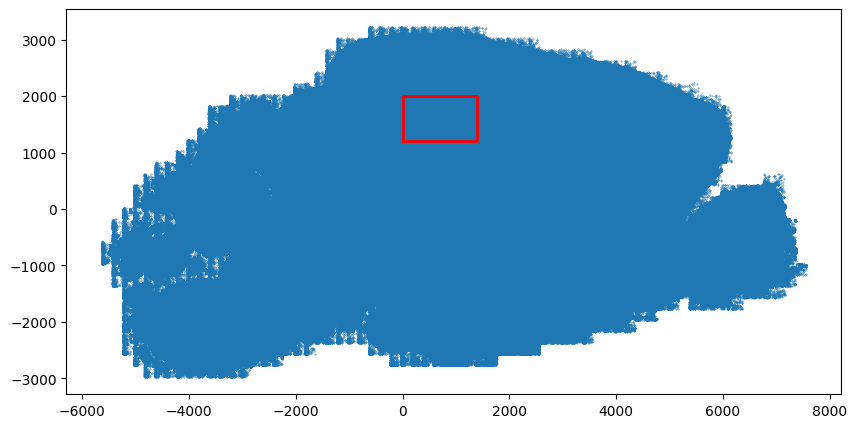

In [118]:
decode1 = decode[decode['global_z'] == 0]
plt.figure(figsize=(10,5))
plt.scatter(decode1['global_x'], decode1['global_y'], s=0.1)
# Define the boundary of the rectangle
# x_min, x_max = 0, 2100
# y_min, y_max = 1200, 1900

x_min, x_max = 0, 1400
y_min, y_max = 1200, 2000

# x_min, x_max = 1000, 1300
# y_min, y_max = 1400, 1600
# x_min, x_max = 1000, 1400
# y_min, y_max = 1350, 1550
# Four vertices of rectangular
rect_x = [x_min, x_max, x_max, x_min, x_min]
rect_y = [y_min, y_min, y_max, y_max, y_min]
# Draw the rectangular boundary
plt.plot(rect_x, rect_y, color='red', linewidth=2)

In [119]:
th = decode[(decode['global_x'] >x_min) &((decode['global_x'] <x_max)) & (decode['global_y'] >y_min) &((decode['global_y'] <y_max))]
th_out = th[th['cell_id'] == '-1']
th_in = th[th['cell_id'] != '-1']
th_out

,barcode_id,global_x,global_y,global_z,x,y,fov,target_gene,cell_id
53389403,13,1389.816000,1826.8329,0.0,349.59702,104.246605,610,Lamp5,-1
53389409,13,1377.533300,1835.3567,0.0,236.91116,182.447480,610,Lamp5,-1
53389414,13,1384.640400,1855.5872,0.0,302.11380,368.047300,610,Lamp5,-1
53389421,13,1371.650600,1863.4064,0.0,182.94237,439.783450,610,Lamp5,-1
53389431,13,1382.553200,1883.7363,0.0,282.96545,626.296630,610,Lamp5,-1
...,...,...,...,...,...,...,...,...,...
74074183,1236,92.978540,1863.2688,4.0,1296.04160,438.521670,837,Itih5,-1
74074185,1236,105.203530,1954.1355,4.0,1408.19750,1272.160500,837,Itih5,-1
74074187,1236,103.284550,1969.9293,4.0,1390.59230,1417.058100,837,Itih5,-1
74074190,1237,24.977634,1992.4144,4.0,672.18020,1623.344200,837,blank-167,-1


 40%|████      | 765/1905 [00:09<00:14, 78.26it/s]

Skipping group 221281312322036888133953509642918615095 due to insufficient points (2 points)


 91%|█████████ | 1735/1905 [00:22<00:01, 86.31it/s]

Skipping group 69904789184529410098916752207953295576 due to insufficient points (1 points)


 96%|█████████▋| 1835/1905 [00:23<00:00, 87.43it/s]

Skipping group 85597928504424692559439686832524183758 due to insufficient points (1 points)


100%|██████████| 1905/1905 [00:24<00:00, 76.94it/s]


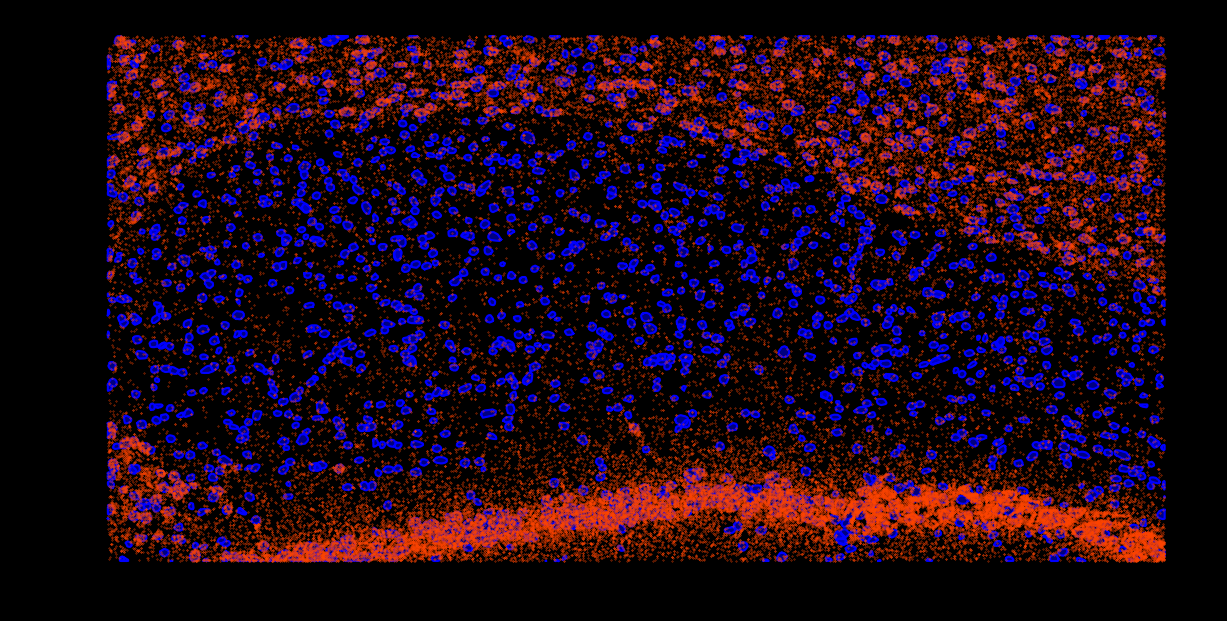

In [121]:
import random

xy = th_in[['global_x', 'global_y']].values
groups = th_in['cell_id'].values
# Get the unique group
unique_groups = np.unique(groups)
# Set color
# colors = ['#43978F', '#9EC4BE', '#ABD0F1', '#DCE9F4', '#E56F5E', '#F19685', '#F6C957', '#FFB77F', '#FBE8D5']
# colors = ['#427AB2', '#F09148', '#FF9896',  '#DBDB8D', '#C59D94', '#AFC7E8']
# colors = ["#6bad6b"]


# Set drawing
fig, ax = plt.subplots(figsize=(15,7.5))

fig.patch.set_facecolor('black')  # Set graphical background color
ax.set_facecolor('black')         # Set the background color of the coordinate axis

# Calculate the convex bag of each group and draw
for group in tqdm(unique_groups):
    # Extraction belongs to this group
    points = xy[groups == group]
    
    # Remove the duplication point
    points = np.unique(points, axis=0)
    
    # The number of points in the inspection group requires at least 3 points to calculate the convex bag
    if points.shape[0] < 3:
        print(f"Skipping group {group} due to insufficient points ({points.shape[0]} points)")
        continue
    
    # Convert points to floating -point type
    points = points.astype(float)

    # Calculating convex bag
    hull = ConvexHull(points)
    
    # Get the apex of convex bag
    hull_points = points[hull.vertices]
    
    
    # Draw the folding and filling of the convex bag
    plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]),
                np.append(hull_points[:, 1], hull_points[0, 1]), color='blue', linestyle='-')
    
    # Fill the inside of the convex bag
    plt.fill(hull_points[:, 0], hull_points[:, 1], color='blue', alpha=0.5)

x = th[['global_x', 'global_y']].values[:, 0]
y = th[['global_x', 'global_y']].values[:, 1]
labels = th['target_gene'].values
# genes=['Sv2b', 'Satb2', 'Neurod2', 'Neurod6']
genes = ['Slc17a7', 'Fgf13', 'Calb1']

for gene in genes:
    x_a = [x[i] for i in range(len(labels)) if labels[i] in gene]
    y_a = [y[i] for i in range(len(labels)) if labels[i] in gene]

    # Draw a scattered point map
    plt.scatter(x_a, y_a, color='#FF4500', s=0.08, label='a', zorder=10, marker='o') # Tags a point of A

# plt.savefig('cell_seg_mrna.png', dpi=600)